In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import pickle
import data_utils
import matplotlib.pyplot as plt

/Users/shivanikohli/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from collections import Counter

def read_sentences(file_path):
	sentences = []

	with open(file_path, 'r') as reader:
		for s in reader:
			sentences.append(s.strip())

	return sentences

def iteritems(dic):
    return iter([(key, dic[key]) for key in dic])

def create_dataset(en_sentences, de_sentences):

	en_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in en_sentences for word in sentence.split())
	de_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in de_sentences for word in sentence.split())

	en_vocab = list(map(lambda x: x[0], sorted(en_vocab_dict.items(), key = lambda x: -x[1])))
	de_vocab = list(map(lambda x: x[0], sorted(de_vocab_dict.items(), key = lambda x: -x[1])))

	en_vocab = en_vocab[:20000]
	de_vocab = de_vocab[:30000]

	start_idx = 2
	en_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(en_vocab)])
	en_word2idx['<ukn>'] = 0
	en_word2idx['<pad>'] = 1

	en_idx2word = dict([(idx, word) for word, idx in iteritems(en_word2idx)])


	start_idx = 4
	de_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(de_vocab)])
	de_word2idx['<ukn>'] = 0
	de_word2idx['<go>']  = 1
	de_word2idx['<eos>'] = 2
	de_word2idx['<pad>'] = 3

	de_idx2word = dict([(idx, word) for word, idx in iteritems(de_word2idx)])

	x = [[en_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in en_sentences]
	y = [[de_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in de_sentences]

	X = []
	Y = []
	for i in range(len(x)):
		n1 = len(x[i])
		n2 = len(y[i])
		n = n1 if n1 < n2 else n2 
		if abs(n1 - n2) <= 0.3 * n:
			if n1 <= 15 and n2 <= 15:
				X.append(x[i])
				Y.append(y[i])

	return X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab

def save_dataset(file_path, obj):
	with open(file_path, 'wb') as f:
		pickle.dump(obj, f, -1)

def main():
    en_sentences = read_sentences('bible.en')
    de_sentences = read_sentences('bible.san')

    save_dataset('./bible.pkl', create_dataset(en_sentences, de_sentences))
    save_dataset('./bible2.pkl', create_dataset(de_sentences, en_sentences))

In [5]:
main()

In [6]:
# read dataset
def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f,encoding="utf_8")

X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = read_dataset('bible2.pkl')

In [8]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [9]:
np.array(Y_test).shape

(9, 17)

In [10]:
# build a model

input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [11]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [12]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [13]:
# ops and hyperparameters
learning_rate = 0.01
batch_size = 64
steps = 1000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [12]:
# sess=tf.Session()    
# #First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('checkpointsSan/-199.meta')
# saver.restore(sess,tf.train.latest_checkpoint('checkpointsSan'))

In [14]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
# del saver
saver = tf.train.Saver()
# restore = True

print('------------------TRAINING------------------')
with tf.Session() as sess:
#     if (restore):
#         saver.restore(sess, tf.train.latest_checkpoint('checkpointsSan/'))
    
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpointsSan2Eng/', global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
step: 0, loss: 7.971765041351318
step: 4, loss: 7.9435601234436035
step: 9, loss: 7.998272895812988
step: 14, loss: 7.989370346069336
step: 19, loss: 7.968928813934326
Checkpoint is saved
step: 24, loss: 7.974762916564941
step: 29, loss: 7.903650760650635
step: 34, loss: 7.85491943359375
step: 39, loss: 7.802876949310303
Checkpoint is saved
step: 44, loss: 7.416131019592285
step: 49, loss: 6.534648895263672
step: 54, loss: 6.0618577003479
step: 59, loss: 5.861288070678711
Checkpoint is saved
step: 64, loss: 5.809093475341797
step: 69, loss: 5.178417205810547
step: 74, loss: 5.660608291625977
step: 79, loss: 4.575555324554443
Checkpoint is saved
step: 84, loss: 6.619039058685303
step: 89, loss: 5.202486991882324
step: 94, loss: 4.522871017456055
step: 99, loss: 4.375219345092773
Checkpoint is saved
step: 104, loss: 4.042259216308594
step: 109, loss: 4.2842864990234375
step: 114, loss: 10.245833396911621
step: 119, loss: 4.766635894775391
Chec

step: 964, loss: 0.0012643396621569991
step: 969, loss: 0.002305768197402358
step: 974, loss: 0.006669139489531517
step: 979, loss: 4.075112428836292e-06
Checkpoint is saved
step: 984, loss: 0.14210419356822968
step: 989, loss: 0.09115472435951233
step: 994, loss: 0.138443261384964
step: 999, loss: 0.000737030990421772
Checkpoint is saved
Training time for 1000 steps: 1823.06853723526s


In [ ]:
tf.restore()

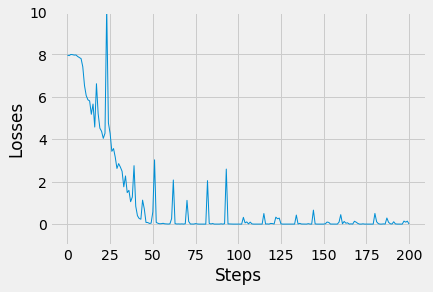

In [15]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((-1, 10))

plt.show()

In [19]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ["\u0907\u092c\u094d\u0930\u093e\u0939\u0940\u092e\u0903 \u0938\u0928\u094d\u0924\u093e\u0928\u094b \u0926\u093e\u092f\u0942\u0926\u094d \u0924\u0938\u094d\u092f ", "or if he ask a fish, will he give him a serpent?", "will he give him a serpent?", 'I am reading a book',\
                    '\u0938\u0928\u094d\u0924\u093e\u0928\u094b \u092f\u0940\u0936\u0941\u0916\u094d\u0930\u0940\u0937\u094d\u091f\u0938\u094d\u0924\u0938\u094d\u092f', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpointsSan2Eng')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print(en_sentences[i])
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print((words[i]), end = " ")
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print(words[i], end = " ")
            
            print('\n--------------------------------')

INFO:tensorflow:Restoring parameters from checkpointsSan2Eng/-999
1.
--------------------------------
इब्राहीमः सन्तानो दायूद् तस्य 
While they behold your chaste conversation coupled with fear  coupled now twelve  twelve While they behold your chaste conversation coupled with fear  coupled now twelve  twelve 
--------------------------------
2.
--------------------------------
or if he ask a fish, will he give him a serpent?
While they behold your chaste twelve  twelve  coupled of seed of seed of While they behold your chaste twelve  twelve  coupled of seed of seed of 
--------------------------------
3.
--------------------------------
will he give him a serpent?
While they behold your chaste conversation coupled with fear  spirits in fear  at While they behold your chaste conversation coupled with fear  spirits in fear  at 
--------------------------------
4.
--------------------------------
I am reading a book
While they behold your chaste conversation coupled at coupled with fear 

# This model can be improved by using more training steps, better dataset or even with better selection of hyperparameters 